In [174]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
import junctionart.extensions as extensions, os
from junctionart.library.Configuration import Configuration
from sympy import symbols, Eq, solve, expand
from shapely.geometry import LineString

In [1]:
%load_ext autoreload
%autoreload 2

### Getting roundabouts

In [452]:
with open("_roundabout3ways.pickle", 'rb') as r3:
    r3s = pickle.load(r3)
    print(type(r3s))

<class 'list'>


In [5]:
ra = r3s[1]

In [14]:
config = Configuration()
def showRoundabout(roundabout):
    extensions.view_road(roundabout.odr, os.path.join("..", config.get("esminipath")))

/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


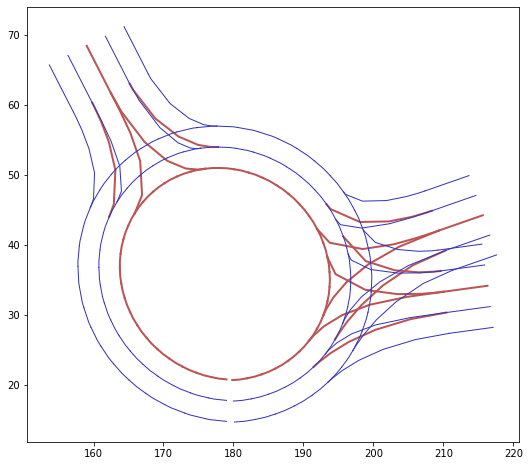

In [453]:
showRoundabout(r3s[6])

In [91]:
# Idea
# For each connection roads
# Get the parampoly in list (for example for 3 incident roads of 2 lanes, there should be 3*2*2 = 12 parampolis
# for all the parampoly, make sure there are no overlap, if there are call it invalid road

In [105]:
r3s[8].incomingConnectionRoads[3].getAdjustedStartPosition()

(107.75059338900601, 53.598331353515356, 2.659906114477256)

In [287]:
import math

In [177]:
def transform_to_geometric_start_point(x, y, h, x_wrt_origin, y_wrt_origin):
    x_trans = x_wrt_origin*math.cos(h) - y_wrt_origin*math.sin(h) + x
    y_trans = x_wrt_origin*math.sin(h) + y_wrt_origin*math.cos(h) + y
    return x_trans,y_trans

In [320]:
def getCoeffs(roundabout):
    coeffs = []
    isIncoming = []
    for i in range(len(roundabout.incomingConnectionRoads)):
        connectionRoad = roundabout.incomingConnectionRoads[i]
        u_coeffs, v_coeffs = getTransformedParampoly(connectionRoad)
        coeffs.append((u_coeffs, v_coeffs))
        isIncoming.append(True)
        
    for i in range(len(roundabout.outgoingConnectionRoads)):
        connectionRoad = roundabout.outgoingConnectionRoads[i]
        ppoly = connectionRoad.planview._raw_geometries[0]
        u_coeffs, v_coeffs = getTransformedParampoly(connectionRoad)
        coeffs.append((u_coeffs, v_coeffs))
        isIncoming.append(False)
    return coeffs, isIncoming
        
def is_intersect(roundabout, nPoints = 10):
    coeffs, isIncoming = getCoeffs(roundabout)
    for i in range(len(coeffs)):
        if isIntersectWithCircle(roundabout, coeffs[i], isIncoming[i], nPoints):
            return True
    for i in range(len(coeffs)):
        for j in range(i + 1, len(coeffs)):
            if find_intersection_point_by_coeffs(coeffs[i], coeffs[j], nPoints):
                return True
            
    return False
            
def getTotalOffset(roundabout, nPoints = 10):
    coeffs, isIncoming = getCoeffs(roundabout)
    offsets = []
    center = roundabout.center
    for i, coeff in enumerate(coeffs):
        flip = isIncoming[i]
        points = getPointsFromCoeff(coeff, nPoints)
        pointA = points[-1] if flip else points[0] 
        pointB = points[0] if flip else points[-1]

        angle = np.rad2deg(np.arctan2(pointB[1] - pointA[1], pointB[0] - pointA[0]))
        angle2 = np.rad2deg(np.arctan2(center.y - pointA[1], center.x - pointA[0]))
        offset = np.abs(angle - angle2)
        offset = offset if offset < 180 else 360 - offset
        offsets.append(offset)
        
    return np.array(offsets)
     
def score(roundabout):
    if is_intersect(roundabout):
        return 0
    
    return getTotalOffset(roundabout).mean()

def getPointsFromCoeff(coeffs, nPoints):
    u_coeffs, v_coeffs = coeffs
    x, y = get_coordinate_wrt_origin(u_coeffs, v_coeffs, nPoints)
    points = [(x[i], y[i]) for i in range(len(x))]
    return points
    
def find_intersection_point_by_coeffs(coeffs1, coeffs2, nPoints=10):
    u_coeffs1, v_coeffs1 = coeffs1
    u_coeffs2, v_coeffs2 = coeffs2
    x1, y1 = get_coordinate_wrt_origin(u_coeffs1, v_coeffs1, nPoints)
    x2, y2 = get_coordinate_wrt_origin(u_coeffs2, v_coeffs2, nPoints)
    points1 = [(x1[i], y1[i]) for i in range(len(x1))]
    points2 = [(x2[i], y2[i]) for i in range(len(x2))]
    line1 = LineString(points1[1:len(points1) -1])
    line2 = LineString(points2[1:len(points2) - 1])
    # plt.plot(*line1.xy)
    # plt.plot(*line2.xy)
    # if line1.intersects(line2):
    #     plt.plot(x1, y1)
    #     plt.plot(x2, y2)
    #     plt.show()
  
    return line1.intersects(line2)

def isIntersectWithCircle(roundabout, coeffs1, isIncoming, nPoints=10):
    u_coeffs1, v_coeffs1 = coeffs1
    x1, y1 = get_coordinate_wrt_origin(u_coeffs1, v_coeffs1, nPoints)
    points1 = [(x1[i], y1[i]) for i in range(len(x1))]

    line1 = LineString(points1[3:len(points1) -1]) if isIncoming else LineString(points1[1:len(points1) -3])
    circle = LineString([(point.x, point.y) for point in roundabout.circularRoadStartPoints])
    plt.plot(*line1.xy)
    plt.plot(*circle.xy)
    return line1.intersects(circle)
    
    
def find_intersection_point(u_coefs, v_coefs):
    t = symbols('t')
   
    # Compute the x-coordinate for both functions
    x_u = u_coefs[0] + u_coefs[1]*t + u_coefs[2]*t**2 + u_coefs[3]*t**3
    x_v = v_coefs[0] + v_coefs[1]*t + v_coefs[2]*t**2 + v_coefs[3]*t**3
    
    # Set x_u = x_v and solve for t
    eq = Eq(x_u, x_v)
    t_solution = solve(eq, t)
    sols = [sol for sol in t_solution if sol.is_real and 0 < sol < 1]
    
    for sol in sols:
        # Substitute the t_solution into either function to obtain the y-coordinate
        y1 = u_coefs[4] + u_coefs[5]*sol + u_coefs[6]*sol**2 + u_coefs[7]*sol**3
        y2 = v_coefs[4] + v_coefs[5]*sol + v_coefs[6]*sol**2 + v_coefs[7]*sol**3
        intersection_point1 = (x_u.subs(t, sol), y1)
        intersection_point2 = (x_v.subs(t, sol), y2)
        if math.fabs(y1 - y2) < 5: 
            return 
    
    # Return the intersection point as a tuple (x, y)
    # return intersection_point

/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


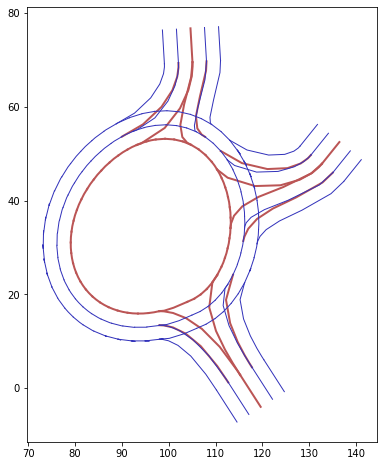

20.457669464377428

In [495]:
showRoundabout(r3s[8])
score(r3s[8])

In [176]:
# for roundabout in r3s:
#     print(score(roundabout))
#     showRoundabout(roundabout)

In [205]:
coeffs = getCoeffs(r3s[1])
u_coeffs, v_coeffs = coeffs[14]
x, y = get_coordinate_wrt_origin(u_coeffs, v_coeffs, step = 4)
plt.plot(x, y)
u_coeffs, v_coeffs = coeffs[17]
x, y = get_coordinate_wrt_origin(u_coeffs, v_coeffs, step = 4)
plt.plot(x, y)

find_intersection_point_by_coeffs(coeffs[14], coeffs[17])

# for u_coeffs, v_coeffs in coeffs:
#     x, y = get_coordinate_wrt_origin(u_coeffs, v_coeffs, step = 4)
#     plt.plot(x, y)
plt.show()

NameError: name 'r3s' is not defined

3
3


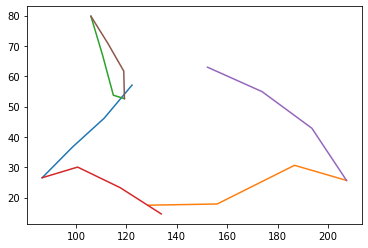

True


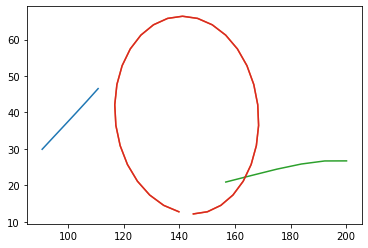

In [321]:
# roundabout = r3s[8]
print(len(roundabout.incomingConnectionRoads))
print(len(roundabout.outgoingConnectionRoads))
for i in range(len(roundabout.incomingConnectionRoads)):
    connectionRoad = roundabout.incomingConnectionRoads[i]
    x, y = getTransformedPoints(connectionRoad)
    plt.plot(x, y)
    
      
for i in range(len(roundabout.outgoingConnectionRoads)):
    connectionRoad = roundabout.outgoingConnectionRoads[i]
    x, y = getTransformedPoints(connectionRoad)
    plt.plot(x, y)


plt.show()
print(is_intersect(roundabout))
plt.show()

In [171]:
def calculate_parametric_cubic_equation(points):
    t = symbols('t')
    
    # Extract the x and y coordinates of the given points
    x0, y0 = points[0]
    x1, y1 = points[1]
    x2, y2 = points[2]
    x3, y3 = points[3]
    
    # Calculate the coefficients for the parametric cubic equation
    uA = x0
    uB = 3*(x1 - x0)
    uC = 3*(x2 - 2*x1 + x0)
    uD = x3 - 3*x2 + 3*x1 - x0
    
    vA = y0
    vB = 3*(y1 - y0)
    vC = 3*(y2 - 2*y1 + y0)
    vD = y3 - 3*y2 + 3*y1 - y0
    
    # Construct the parametric cubic equation
    x_t = uA + uB*t + uC*t**2 + uD*t**3
    y_t = vA + vB*t + vC*t**2 + vD*t**3
    
    # Expand the equation for better readability
    # x_t = expand(x_t)
    # y_t = expand(y_t)
    
    # Return the equations for x(t) and y(t)
    return [uA, uB, uC, uD], [vA, vB, vC, vD]

def getTransformedParampoly(polyRoad):
    # Get start Point
    x_start, y_start, h_start = polyRoad.planview.get_start_point()
 
    # Get four points
    ppoly = polyRoad.planview._raw_geometries[0]
    x, y = get_coordinate_wrt_origin([ppoly.au, ppoly.bu, ppoly.cu, ppoly.du], [ppoly.av, ppoly.bv, ppoly.cv, ppoly.dv], step = 4)

    # Transform these four points
    x, y = transform_to_geometric_start_point(x_start, y_start, h_start, x, y)
    
    points = []
    for i in range(len(x)):
        points.append((x[i], y[i]))
    u_coeffs, v_coeffs = calculate_parametric_cubic_equation(points)
    
    # x, y = get_coordinate_wrt_origin(u_coeffs, v_coeffs, step = 100)
    return u_coeffs, v_coeffs

def getTransformedPoints(polyRoad):
    # Get start Point
    x_start, y_start, h_start = polyRoad.planview.get_start_point()
   
    # Get four points
    ppoly = polyRoad.planview._raw_geometries[0]
    x, y = get_coordinate_wrt_origin([ppoly.au, ppoly.bu, ppoly.cu, ppoly.du], [ppoly.av, ppoly.bv, ppoly.cv, ppoly.dv], step = 4)

    # Transform these four points
    x, y = transform_to_geometric_start_point(x_start, y_start, h_start, x, y)
    

    return x, y

In [172]:
def get_coordinate_wrt_origin(u_coeffs, v_coeffs, step):
    
    array_size = np.int64((1/step)+1)
    
    coff1 = np.array([u_coeffs])
    coff2 = np.array([v_coeffs])

    mat_i = np.linspace(0.0, 1.0, step, dtype=np.float64)
    new_mat = np.zeros((4, step))
    
    for i in range(4):
        new_mat[i] = mat_i**i
   
    xVal = coff1.dot(new_mat)
    yVal = coff2.dot(new_mat)

    return xVal[0], yVal[0]

In [132]:
import matplotlib.pyplot as plt

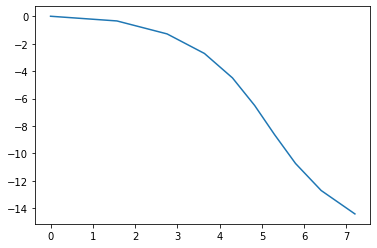

In [141]:
plt.plot(x, y)
plt.show()

In [171]:
x, y = get_coordinate_wrt_origin([ppoly.au, ppoly.bu, ppoly.cu, ppoly.du], [ppoly.av, ppoly.bv, ppoly.cv, ppoly.dv], step = 10)

(array([ 0.        ,  2.42950863,  4.6748636 ,  6.7621012 ,  8.71725772,
        10.56636943, 12.33547261, 14.05060355, 15.73779852, 17.42309381]),
 array([  0.        ,  -0.3171435 ,  -1.20051743,  -2.54803691,
         -4.25761708,  -6.22717307,  -8.35462001, -10.53787304,
        -12.6748473 , -14.6634579 ]))

In [ ]:
for rb in r3s:
    sum = 0
    for circularRoad in rb.circularRoads:
        sum += circularRoad.length()
    
    print(sum, 2*np.pi*rb.radius)

In [ ]:
df = pd.DataFrame(columns = ['totalCircularLength', 'Apparent Circumferance', 'circular irregularity ratio', 'radius', 'Max Incident Angle', 'Min Incident Angle'])

In [ ]:
for i, rb in enumerate(r3s):
    sum = 0
    for circularRoad in rb.circularRoads:
        sum += circularRoad.length()
    apparent_sum = 2*np.pi*rb.radius
    offsetsInRadians = [np.abs(offset * np.pi / 2) for offset in rb.offsets]
    offsetsInDegress = np.degrees(offsetsInRadians)
    df.loc[i] = [sum, apparent_sum, sum / apparent_sum, rb.radius, np.max(offsetsInDegress), min(offsetsInDegress)]

In [ ]:
df

In [92]:
r3s[0].circularRoads[0].planview._raw_geometries[0].get_attributes()

{'aU': '0.0',
 'bU': '3.0',
 'cU': '-5.347483535403546',
 'dU': '3.5619540543393873',
 'aV': '0.0',
 'bV': '0.0',
 'cV': '-0.4058873918984967',
 'dV': '0.3484422688897568',
 'pRange': 'normalized'}

In [ ]:
# roundabout = r3s[15]
x = []
y = []
radius = []
fig, ax = plt.subplots(figsize = (10,2))
for i, roundabout in enumerate(r3s):
    k = []
    print(i)
    for circularRoad in roundabout.circularRoads:
        xstart, ystart, hstart = circularRoad.planview.get_end_point() 
        xend, yend, hend = circularRoad.planview.get_end_point()
        print(xstart, ystart, ' | ', xend, yend , ' | ')

        k.append(math.sqrt((roundabout.center.x - xstart) ** 2 + (roundabout.center.y - ystart)**2))
    #     print((roundabout.center.x - xend) ** 2 + (roundabout.center.y - yend)**2)
    df_temp = pd.DataFrame(k)

#     ax = df_temp.plot(kind = "hist", density = True, bins = 15) 
    if(roundabout.radius > 30 and roundabout.radius < 50):
        ax = df_temp.plot(kind = "kde", ax = ax , legend=False, title="Distribution of radius in several 3 way Roundabouts")
    

In [ ]:
fig.savefig('3waysWithLessRadius')

In [8]:
x = []
y = []
rid = []
radius = []
for i, roundabout in enumerate(r3s):
#     if roundabout.radius > 30:
#         continue
    for circularRoad in roundabout.circularRoads:
        xstart, ystart, hstart = circularRoad.planview.get_end_point() 
        xend, yend, hend = circularRoad.planview.get_end_point()
        x.append(xstart)
        y.append(ystart)
        rid.append(i) 
        radius.append(math.sqrt((roundabout.center.x - xstart) ** 2 + (roundabout.center.y - ystart)**2))
data = {"id":rid, "x":x, "y":y, "Radius":radius}    
data = pd.DataFrame(data)

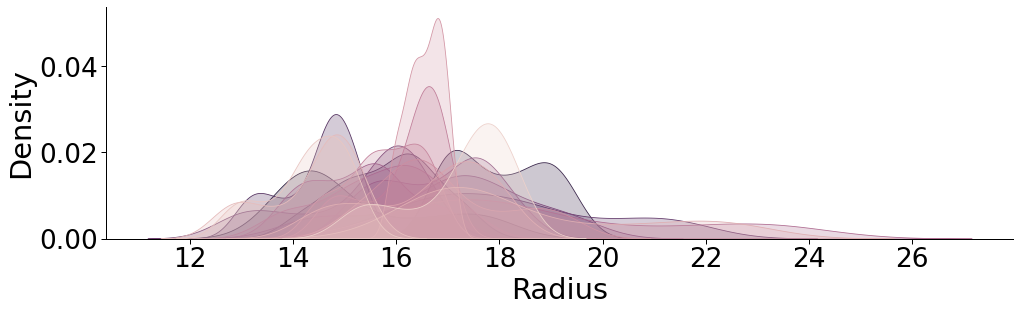

In [10]:
sns.set_context("paper", font_scale=3)

g = sns.displot(data, x="Radius", kind="kde", hue="id", fill=True, aspect = 3)
# g.ax.set_xlim(14,18)
g._legend.remove()
# plt.savefig('3wayFixedFinal.png')

In [ ]:
# roundabout = r3s[1]
fig, ax = plt.subplots(figsize = (10,2))
for j, roundabout in enumerate(r3s):
    if(roundabout.radius > 30 and roundabout.radius < 50):
        continue
    k = []
    x = []
    y = []
    for circularRoad in roundabout.circularRoads:
        xstart, ystart, hstart = circularRoad.planview.get_end_point() 
        xend, yend, hend = circularRoad.planview.get_end_point()

        x.append(xend)
        y.append(yend)
        k.append(math.sqrt((roundabout.center.x - xstart) ** 2 + (roundabout.center.y - ystart)**2))
    #     print((roundabout.center.x - xend) ** 2 + (roundabout.center.y - yend)**2)
    # df_temp = pd.DataFrame(k)

    #     ax = df_temp.plot(kind = "hist", density = True, bins = 15) 
    drdp = []
    for i in range(len(k) - 2):
        try:
            drdp.append( (k[i + 1] - k[i]) / math.dist((x[i+1], y[i+1]), (x[i], y[i])) )
        except ZeroDivisionError:
            print(i, roundabout.radius, math.dist((x[i+1], y[i+1]), (x[i], y[i])))

    df_temp = pd.DataFrame(drdp)
    ax = df_temp.plot(kind = "kde", ax=ax, legend=False, title="Distribution of dr/dDistance in a 3way Roundabout")

In [ ]:
fig.savefig('3waysDerivative')

In [12]:
ids = []
dr = []
radius = []
for j, roundabout in enumerate(r3s):
#     if(roundabout.radius > 30 ):
#         continue
    k = []
    x = []
    y = []
    for circularRoad in roundabout.circularRoads:
        xstart, ystart, hstart = circularRoad.planview.get_end_point() 
        xend, yend, hend = circularRoad.planview.get_end_point()

        x.append(xend)
        y.append(yend)
        k.append(math.sqrt((roundabout.center.x - xstart) ** 2 + (roundabout.center.y - ystart)**2))
    #     print((roundabout.center.x - xend) ** 2 + (roundabout.center.y - yend)**2)
    # df_temp = pd.DataFrame(k)

    #     ax = df_temp.plot(kind = "hist", density = True, bins = 15) 
    drdp = []
    for i in range(len(k) - 2):
        try:
            drdp.append( (k[i + 1] - k[i]) / math.dist((x[i+1], y[i+1]), (x[i], y[i])) )
            ids.append(j)
            dr.append((k[i + 1] - k[i]) / math.dist((x[i+1], y[i+1]), (x[i], y[i])))
            radius.append(k[i])
            
        except ZeroDivisionError:
            print(i, roundabout.radius, math.dist((x[i+1], y[i+1]), (x[i], y[i])))

data = {"ID" : ids, "dRadius/dDistance" : dr, "Radius": radius}
data = pd.DataFrame(data)

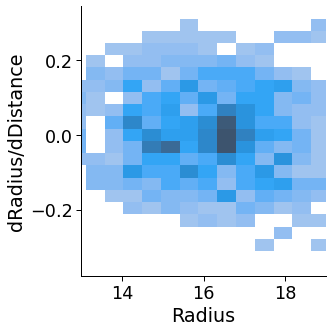

In [18]:
sns.set_context("paper", font_scale=2)
# g = sns.displot(data, x="dRadius/dDistance", kind="kde", hue="ID", fill=True, aspect = 2)
# g._legend.remove()
g=sns.displot(data, x="Radius", y = "dRadius/dDistance", aspect = 1)
g.ax.set_xlim(13,19)
# data

plt.savefig('3wayRadiusVsDerivative.png')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for i, roundabout in enumerate(r3s):
    k = []
    x = []
    y = []
    for circularRoad in roundabout.circularRoads:
        xstart, ystart, hstart = circularRoad.planview.get_end_point() 
        xend, yend, hend = circularRoad.planview.get_end_point()

        x.append(xend)
        y.append(yend)
        k.append(math.sqrt((roundabout.center.x - xstart) ** 2 + (roundabout.center.y - ystart)**2))
        df_xy = pd.DataFrame()
        df_xy['x'] = x
        df_xy['y'] = y
    # ax = df_temp.plot(kind = "kde", ax=ax, legend=False, title="Distribution of dr/dDistance in a 3way Roundabout")
    df_xy.x = (df_xy.x - df_xy.x.mean(0)) / df_xy.x.std(0)
    df_xy.y = (df_xy.y - df_xy.y.mean(0)) / df_xy.y.std(0)
    points = [(p.x, p.y) for p in df_xy.iloc]
    polygon = Polygon(points)
    ax.plot(*polygon.exterior.xy)


sampleCircle = Point(0,0).buffer(1.3)
ax.plot(*sampleCircle.exterior.xy, color='black', linewidth=5)
# ax.set_title('Regular Circle vs Created Roundabouts (Normalized)')

In [ ]:
fig.savefig('CirclevsRoundaboutBetter')

In [ ]:
asf= LineString([(1, 2), (12, 12), (-4, 1), (35, 1)]).interpolate(1)

In [ ]:
# ax.plot(*polygon.exterior.xy)
for point in polygon.coords:
    print(point)

In [ ]:
def get_coeffs(road):
    coeffs = np.zeros((4, 2))
#     print("start s ", road.planview._adjusted_geometries[0].s)
    coeffs[0][0] = road.planview._adjusted_geometries[0].geom_type.au
    coeffs[1][0] = road.planview._adjusted_geometries[0].geom_type.bu
    coeffs[2][0] = road.planview._adjusted_geometries[0].geom_type.cu
    coeffs[3][0] = road.planview._adjusted_geometries[0].geom_type.du
    coeffs[0][1] = road.planview._adjusted_geometries[0].geom_type.av
    coeffs[1][1] = road.planview._adjusted_geometries[0].geom_type.bv
    coeffs[2][1] = road.planview._adjusted_geometries[0].geom_type.cv
    coeffs[3][1] = road.planview._adjusted_geometries[0].geom_type.dv
    return coeffs

In [ ]:
get_coeffs(r3s[0].circularRoads[0])
Geometry.Geometry.evalPoly()

In [ ]:
s = np.linspace(0, 1, 10)
coeffs = get_coeffs(r3s[0].circularRoads[0])
points = Geometry.Geometry.evalPoly(coeffs.copy(), s)

In [ ]:
points

In [ ]:
coeffs

In [ ]:
s

In [ ]:
vals = []
for k in s :
    val = coeffs[0] + k * coeffs[1] + k*k*coeffs[2] + k*k*k*coeffs[3]
    vals.append(val)

In [ ]:
vals = np.array(vals)

In [ ]:
def get_points(road):
    s = np.linspace(0, 1, 10)
    coeffs = get_coeffs(road)
#     print(coeffs)
    vals = []
    for k in s :
        val = coeffs[0] + k * coeffs[1] + k*k*coeffs[2] + k*k*k*coeffs[3]
        vals.append(val)
       
    x = road.planview._adjusted_geometries[0].x
    y = road.planview._adjusted_geometries[0].y
    hdg = road.planview._adjusted_geometries[0].heading
    points = []
    for a_ in vals:
        u, v = a_
        beta = hdg + np.arctan(v / u) if u != 0 else hdg
        x_ = x + np.sqrt(u*u + v*v) * np.cos(beta)
        y_ = y + np.sqrt(u*u + v*v) * np.sin(beta)
        points.append((x_, y_))
    return points

In [ ]:
a = get_points(r3s[0].circularRoads[0])
x = r3s[0].circularRoads[0].planview._adjusted_geometries[0].x
y = r3s[0].circularRoads[0].planview._adjusted_geometries[0].y
hdg = r3s[0].circularRoads[0].planview._adjusted_geometries[0].heading

In [ ]:
for a_ in a:
    u, v = a_
    beta = hdg + np.arctan(v / u) if u != 0 else hdg
    x_ = x + np.sqrt(u*u + v*v) * np.cos(beta)
    y_ = y + np.sqrt(u*u + v*v) * np.sin(beta)
    print(x_, y_)

In [ ]:
for r in r3s[0].circularRoads:
    for t, l in (get_points(r)):
        print(t, l)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
totRad = 0
for i, roundabout in enumerate(r3s):
#     if(i > 0):
#         break
    k = []
    x = []
    y = []
    for circularRoad in roundabout.circularRoads:
        for x_, y_ in get_points(circularRoad):
            x.append(x_)
            y.append(y_)
#         k.append(math.sqrt((roundabout.center.x - x_) ** 2 + (roundabout.center.y - y_)**2))
        df_xy = pd.DataFrame()
        df_xy['x'] = x
        df_xy['y'] = y
    # ax = df_temp.plot(kind = "kde", ax=ax, legend=False, title="Distribution of dr/dDistance in a 3way Roundabout")
    df_xy.x = (df_xy.x - df_xy.x.mean(0)) / df_xy.x.std(0)
    df_xy.y = (df_xy.y - df_xy.y.mean(0)) / df_xy.y.std(0)
    df_xy['radius'] = (df_xy.x**2 + df_xy.y**2)
    totRad += df_xy.radius.mean(0)
#     points = [(p.x, p.y) for p in df_xy.iloc]
#     polygon = Polygon(points)
#     ax.plot(*polygon.exterior.xy)
    ax.plot(df_xy.x, df_xy.y)
avgRad = math.sqrt(totRad / len(r3s))
print(avgRad)
sampleCircle = Point(0,0).buffer(avgRad)
ax.plot(*sampleCircle.exterior.xy, color='black', linewidth=5)
ax.set_title('Regular Circle vs Created Roundabouts (Normalized)')

In [ ]:
fig.savefig('CirclevsRoundaboutBetter')

In [ ]:
def getOptimalCircle(incidentPoints):
        if len(incidentPoints) == 2:
            center = Point(
                (incidentPoints[0].x + incidentPoints[1].x) / 2,
                (incidentPoints[0].y + incidentPoints[1].y) / 2,
            )
            radius = self.__distance(incidentPoints[0], incidentPoints[1]) / 2
            return center, radius

        sum_x = (
            sum_y
        ) = sum_xx = sum_yy = sum_xy = sum_xxy = sum_xyy = sum_xxx = sum_yyy = 0.0
        A = B = C = D = E = 0.0
        x2 = y2 = xy = xDiff = yDiff = 0.0
        for incidentPoint in incidentPoints:
            sum_x += incidentPoint.x
            sum_y += incidentPoint.y
            x2 = incidentPoint.x * incidentPoint.x
            y2 = incidentPoint.y * incidentPoint.y
            xy = incidentPoint.x * incidentPoint.y
            sum_xx += x2
            sum_yy += y2
            sum_xy += xy
            sum_xxy += x2 * incidentPoint.y
            sum_xyy += y2 * incidentPoint.x
            sum_xxx += x2 * incidentPoint.x
            sum_yyy += y2 * incidentPoint.y

        n = len(incidentPoints)
        A = n * sum_xx - sum_x * sum_x
        B = n * sum_xy - sum_x * sum_y
        C = n * sum_yy - sum_y * sum_y  
        D = 0.5 * (n * (sum_xyy + sum_xxx) - sum_x * sum_yy - sum_x * sum_xx)
        E = 0.5 * (n * (sum_xxy + sum_yyy) - sum_y * sum_xx - sum_y * sum_yy)

        F = A * C - B * B
        centerX = (D * C - B * E) / F
        centerY = (A * E - B * D) / F


        radius = 10000000
        for i in range(n):
            xDiff = incidentPoints[i].x - centerX
            yDiff = incidentPoints[i].y - centerY
            radius = min(radius, (xDiff * xDiff + yDiff * yDiff) ** 0.5)


            return centerX, centerY, radius

In [ ]:
import random
def get_random_circle():
        radius = random.randint(5, 15) #50, 200 chhilo
        center_x = random.randint(0, 200)
        center_y = random.randint(0, 200)
        return center_x, center_y, radius
    
def get_random_point(center_x, center_y, radius):
        angle = random.random()*math.pi*2
        random_x = center_x + radius * math.cos(angle)
        random_y = center_y + radius * math.sin(angle)
        return random_x, random_y
    
def get_fixed_points(center_x, center_y, radius, nPoints):
        points = []
        for i in range(nPoints):
            x, y = get_random_point(center_x, center_y, radius)
            # modified_angle = angle + random.randint(-30, 30)
            # modified_x, modified_y = self.random_gradient_tranlation(modified_angle, x, y)
            points.append((x, y))
            
        return points

In [ ]:
class IncidentPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [ ]:
c_x, c_y, r = get_random_circle()
points = get_fixed_points(c_x, c_y, r, 1111)
points = [IncidentPoint(p[0], p[1]) for p in points]
ans = getOptimalCircle(points)

In [ ]:
print(ans)
print(c_x, c_y, r)

In [3]:
from junctionart.roundabout.LogFlow import LogFlow
from junctionart.roundabout.RewardUtil import RewardUtil
from junctionart.roundabout.RoundaboutLaneEncodingEnv import RoundaboutLaneEncodingEnv
from junctionart.roundabout.GFNAgent import GFNAgent
import math

In [36]:
# threePoints = [
#             {"x": 80, "y": 20, "heading": math.radians(45),'leftLane': 2, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#             {"x": 210, "y": 20, "heading": math.radians(115),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#             # {"x": 100, "y": 90, "heading": math.radians(300),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#             ]
threePoints = [
            {"x": 80, "y": 20, "heading": math.radians(45),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 210, "y": 20, "heading": math.radians(115),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 100, "y": 100, "heading": math.radians(300),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            # {"x": 160, "y": 49, "heading": math.radians(300),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            # {"x": 160, "y": 100, "heading": math.radians(220),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
        ]
# env = RoundaboutLaneEncodingEnv()
# agent = GFNAgent(env, [180, 256, 512, 180], 30, 6, roadDefinitions = threePoints)
states, losses = agent.train(epoch = 50000, updateFrequency=5)

  8%|█████████▉                                                                                                                      | 3890/50000 [17:57<3:32:54,  3.61it/s]

state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
state:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

ValueError: only one element tensors can be converted to Python scalars

In [35]:
import torch
a = torch.zeros(180)
agent.lgF.forward(a)
# torch.multinomial(torch.Tensor(a), 1)
# torch.multinomial(agent.lgF.forward(torch.Tensor(a)), 1)
# agent.getConfigFromEncoding(torch.Tensor(a))

tensor(81)

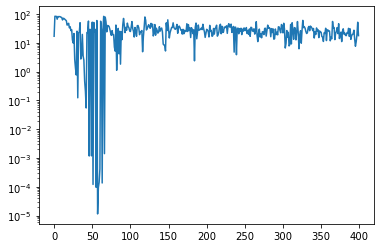

In [37]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.yscale('log')
plt.show()

[9, 25, 23, 9, 25, 21]
0
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


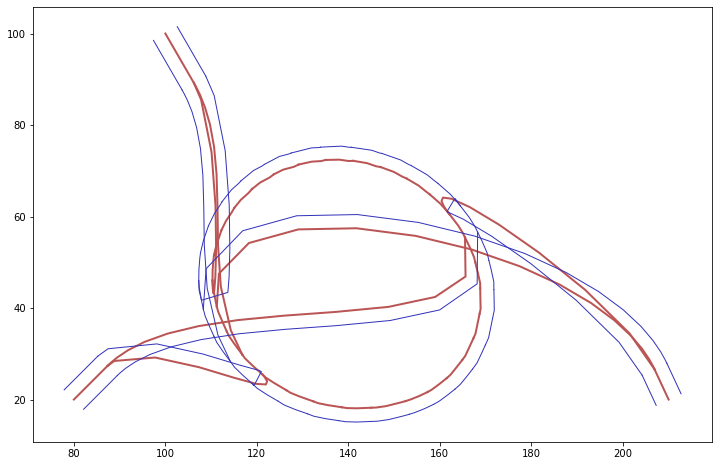

In [57]:
# config = [29, 20, 10, 5, 20, 11]
# config = [29, 26, 8, 10, 1]
config = agent.getConfigFromEncoding(states[-3])
# config = agent.generateTrajectory()
# config = [28, 22, 8, 27, 22, 11]

print(config)

env.generateWithRoadDefinition(threePoints,
            outgoingLanesMerge=False,
            nSegments=30,
            laneToCircularId=config)
roundabout = env.getRoundabout()

print(roundabout.getReward())
roundabout.showRoundabout()

In [818]:
# %load_ext line_profiler
# %lprun -f RewardUtil.getLanePointsFromPolyRoads RewardUtil.getLanePointsFromPolyRoads(roundabout.incomingConnectionRoads[0])

In [471]:
# %%time
# RewardUtil.getCenterAndRightLanesFromRoundabout(roundabout)

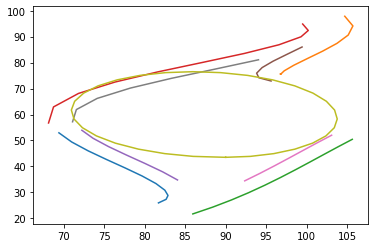

In [8]:
RewardUtil.showRewardView(roundabout)